In [1]:
%matplotlib notebook
DEFAULT_FIGSIZE = (12, 8)

import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_style('darkgrid', {'legend.frameon': True})
import pandas as pd

sys.path.append('..')
from antlia import exp2
from antlia import kalman
from antlia import plot_braking as braking
from antlia import dtc
from antlia.plotdf import plotjoint

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = DEFAULT_FIGSIZE
mpl.rcParams['legend.facecolor'] = 'white'

In [2]:
records = exp2.load_records()

../antlia/trial2.py:1146: UserWarning: Unable to detect cyclist entry for event starting at t = 476.353 seconds
  warnings.warn(msg, UserWarning)
../antlia/trial2.py:1146: UserWarning: Unable to detect cyclist entry for event starting at t = 592.204 seconds
  warnings.warn(msg, UserWarning)
../antlia/trial2.py:1154: UserWarning: Unable to detect cyclist exit or braking for event ending at t = 1288.409 seconds
  warnings.warn(msg, UserWarning)
../antlia/trial2.py:1146: UserWarning: Unable to detect cyclist entry for event starting at t = 1435.910 seconds
  warnings.warn(msg, UserWarning)
../antlia/trial2.py:1146: UserWarning: Unable to detect cyclist entry for event starting at t = 1495.810 seconds
  warnings.warn(msg, UserWarning)
../antlia/trial2.py:1154: UserWarning: Unable to detect cyclist exit or braking for event ending at t = 1575.710 seconds
  warnings.warn(msg, UserWarning)
../antlia/trial2.py:1146: UserWarning: Unable to detect cyclist entry for event starting at t = 296.153 

In [ ]:
records[1]._calculate_trials2(missing_sync=exp2.MISSING_SYNC[1],
                              trial_mask=exp2.TRIAL_MASK[1])

for i, t in enumerate(records[1].trials):
    print(i, t.event.type)
    
records[1].plot_trial_detection(figsize=(7, 8))

In [ ]:
color = sns.color_palette('Paired', 12)[1::2]
plt.close('all')
fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
cart_kw = {'xlim': (-20, 50), 'ylim': (0.5, 3.5)}
x, y = [z.compressed() for z in records[1].trials[3].lidar.cartesian(**cart_kw)]
ax.scatter(x, y, marker='.', color=color[0])

x, y = [z.compressed() for z in records[1].trials[3].event.lidar.cartesian(**cart_kw)]
ax.scatter(x, y, marker='.', color=color[2])

ax.set_xlim(cart_kw['xlim'])
ax.set_ylim(cart_kw['ylim'])
plt.show()

In [3]:
# generate Kalman matrices
f, h, F, H = kalman.generate_fhFH(
    constant_velocity=False,
    wheelbase=0.6)

In [4]:
T = 1/125 # bicycle sample rate
q0 = 1
q1 = 0.01
Q = 1*np.diag([
    q0*T**3/6, # [m] x-position
    q0*T**3/6, # [m] y-position
    q1*T**2/2, # [rad/s] yaw angle
    q0*T**2/2, # [m/s] velocity 
    q1*T, # [rad/s] yaw rate
    q0*T, # [m/s^2] acceleration
])

P0 = np.diag([
    0.1,
    0.1,
    0.01,
    1,
    0.1,
    0.2
])

In [ ]:
braking_df = pd.read_pickle('trial2_braking_ttc.p.gz')

In [ ]:
from antlia import trial2

metrics_kw = {'braking_threshold': 0.1, 'min_size': 75}

def get_metrics(records):
    """Define function to get metrics for lidar data.
    """
    metrics = []
    for i, r in enumerate(records):
        for j, tr in enumerate(r.trials):
            if tr.event.type.value  != trial2.EventType.Braking.value:
                continue
            try:
                m = braking.get_metrics(tr.event.data, **metrics_kw)[0]
            except ValueError:
                print(i, j)
                continue
            m['rider id'] = i
            m['trial id'] = j
            metrics.append(m)
    
    return np.concatenate(metrics)

metrics = get_metrics(records)
braking_df = braking.get_dataframe(metrics)

applying trial specific bbmask


../antlia/trial2.py:1149: UserWarning: Unable to detect cyclist entry for event starting at t = 1435.910 seconds
  msg += 't = {0:.3f} seconds'.format(


z 1435.90965843 1443.25980592


<IPython.core.display.Javascript object>


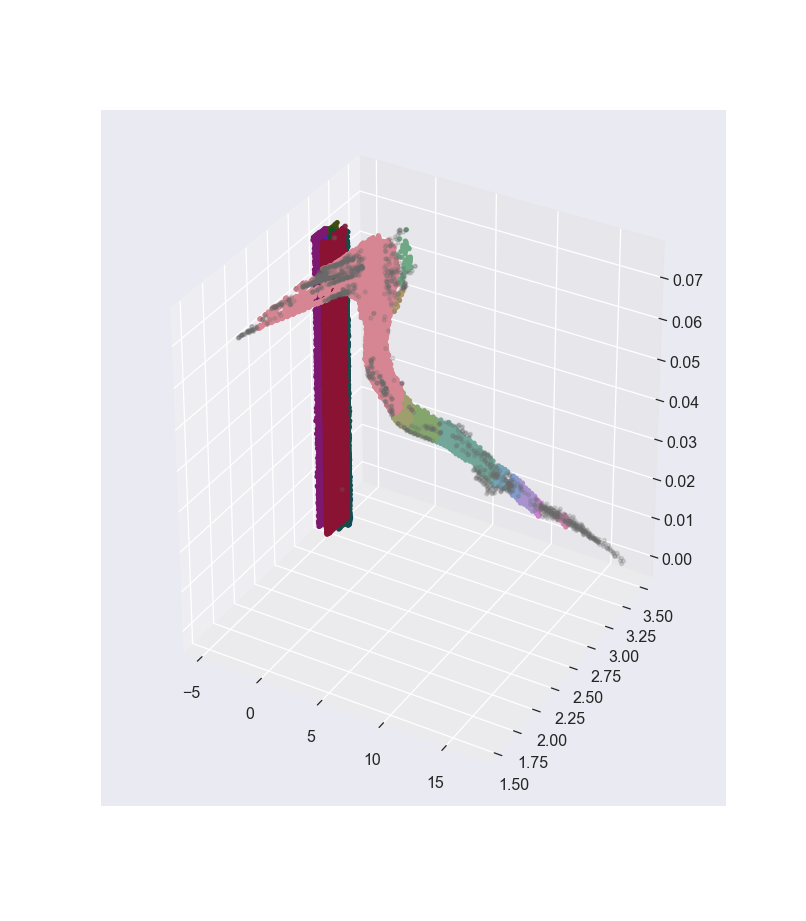

<IPython.core.display.Javascript object>


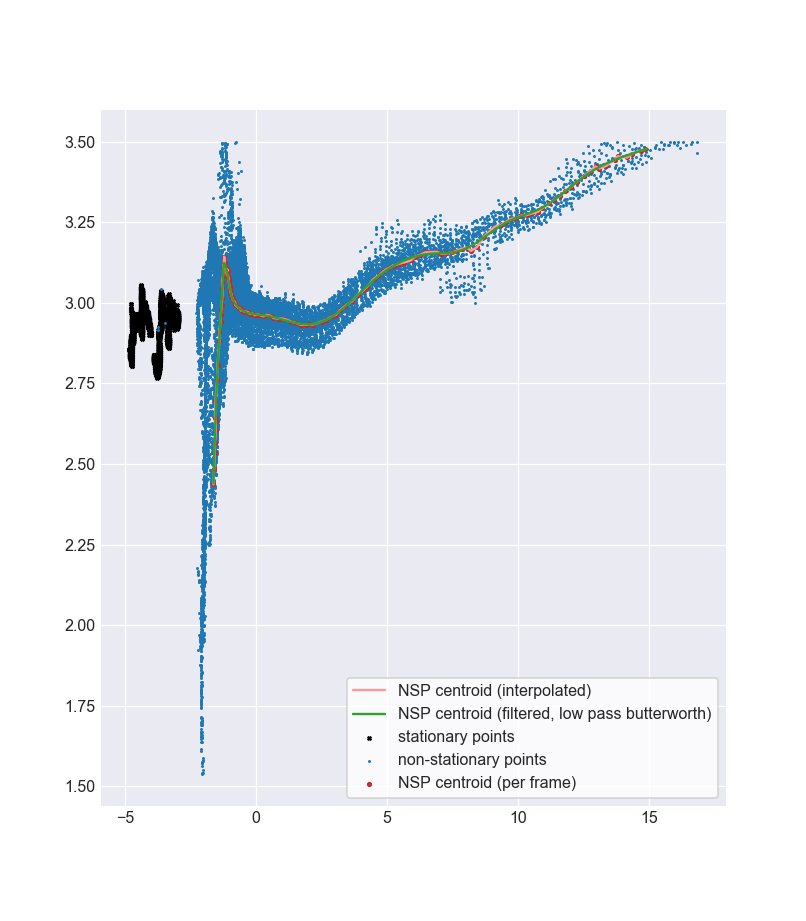

(<Figure size 504x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x274ffaef0>)

In [110]:
%matplotlib notebook 
plt.close('all')
key = (2, 13)
if key in exp2.TRIAL_BBMASK:
    print('applying trial specific bbmask')
    records[key[0]].trials[key[1]]._detect_event(exp2.instructed_eventtype(*key),
                                                 exp2.TRIAL_BBMASK[key])
else:
    records[key[0]].trials[key[1]]._detect_event(exp2.instructed_eventtype(*key))
records[key[0]].trials[key[1]].event.plot_clusters(figsize=(7, 8))
records[key[0]].trials[key[1]].event.plot_trajectory(plot_vel=False, figsize=(7, 8))

In [104]:
#plt.close('all')
#stop
rid = 2
exp2._estimate_state(records[rid], [1])

plt.close('all')
for j, tr in enumerate(records[rid].trials):
    event = tr.event
    
    fig, ax = kalman.plot_kalman_result(
        event.kalman_result,
        event,
        event.kalman_smoothed_result,
        wheelbase=0.6,
        ax_mask=[1, 0, 0, 1, 0],
        figsize=(16, 12))
plt.show()

NameError: name 'stop' is not defined

In [61]:
plt.close('all')
stop
#%matplotlib inline

import scipy.stats
from antlia import trial2

tol = [0, 0, 0, 0]

linregress_kf = []
linregress_ks = []

def velocity_error(event, result):
    v_measured = event.bicycle.speed
    v_estimated = result.state_estimate[:, 3].squeeze()
    assert v_measured.shape == v_estimated.shape
    
    x = np.square(v_measured - v_estimated).sum()
    return x/x.size

plt.close('all')
for i, r in enumerate(records):
    R = kalman.generate_R(r)
    
    for j, tr in enumerate(r.trials):
        event = tr.event
        
        # create measurement array from event data
        z = kalman.generate_measurement(event)
        
        # create initial state estimate
        x0 = kalman.initial_state_estimate(z)
        # replace initial x-position estimate with max from data
        x0[0] = event.x.max()
        # replace trajectory-derived velocity estimate with instructed speed
        x0[3] = exp2.instructed_speed(i, j)
        
        ## check position estimate is reasonable
        #assert x0[0] > 15, 'initial x: {:0.3f}'.format(x0[0])
        #assert x0[1] > 2.0 and x0[1] < 3.5, 'initial y: {:0.3f}'.format(x0[1])
        if x0[0] <= 15:
            print('initial x: {:0.3f}'.format(x0[0]))
        if x0[1] >=3.5 or x0[1] <= 2.0:
            print('initial y: {:0.3f}'.format(x0[1]))
        
        print('rider {} trial {}'.format(i, j))
        print('x0:', x0)
        
        KF = kalman.Kalman(F, H, Q, R, f, h)
        result = KF.estimate(x0, P0, z, tol)
        smooth = KF.smooth_estimate(result)
        ve_kf = velocity_error(event, result)
        ve_ks = velocity_error(event, smooth)
        print('KF v error:', ve_kf)
        print('KS v error:', ve_ks)
        
        if True:
            fig, ax = kalman.plot_kalman_result(result, event, smooth,
                                                wheelbase=0.6,
                                                ax_mask=[1, 0, 0, 1, 0],
                                                figsize=(16, 12))
            # draw instructed speed
            v_inst = exp2.instructed_speed(i, j)
            ax[1].plot(event.bicycle.time[[0, -1]], 2*[v_inst],
                       color='black', linestyle='--',
                       label='instructed speed')
            ax[1].legend()
            plt.show()
        
        #if event.type.value == trial2.EventType.Braking.value:
        #    v_kf = result.state_estimate[:, 3].squeeze()
        #    v_ks = smooth.state_estimate[:, 3].squeeze()
        #    
        #    df_ij = braking_df[(braking_df['rider id'] == i) &
        #                       (braking_df['trial id'] == j)]
        #    
        #    t = event.bicycle.time
        #    t0 = df_ij['braking starttime'].values[0]
        #    tf = df_ij['braking endtime'].values[0]
        #    index = (t >= t0) & (t <= tf)
        #    
        #    # best-fit line metrics
        #    linregress_kf.append(scipy.stats.linregress(
        #        t[index],
        #        v_kf[index]))
        #    linregress_ks.append(scipy.stats.linregress(
        #        t[index],
        #        v_ks[index]))

NameError: name 'stop' is not defined

In [ ]:
df_kf = pd.DataFrame(linregress_kf,
                     columns=[
                         'linregress slope',
                         'linregress intercept',
                         'linregress r-value',
                         'linregress p-value',
                         'linregress stderr',
                     ])
df_ks = pd.DataFrame(linregress_ks,
                     columns=[
                         'linregress slope',
                         'linregress intercept',
                         'linregress r-value',
                         'linregress p-value',
                         'linregress stderr',
                     ])

In [ ]:
slope = []
slope_kf = []
slope_ks = []

for (_, row), (_, row_kf), (_, row_ks) in zip(braking_df.iterrows(),
                                              df_kf.iterrows(),
                                              df_ks.iterrows()):
    a = row['linregress slope']
    b = row_kf['linregress slope']
    c = row_ks['linregress slope']
    
    # skip trial if wheel lockup occurs
    if row['lockup ranges']:
        print('skipping {}-{} due to wheel lockup'.format(
            int(row['rider id']), int(row['trial id'])))
        continue
        
    # skip trial if either fit value exceeds 4 m/s^2
    if abs(a) > 4 or abs(b) > 4 or abs(c) > 4:
        print('skipping {}-{} due to invalid deceleration'.format(
            int(row['rider id']), int(row['trial id'])))
        continue
    slope.append(a)
    slope_kf.append(b)
    slope_ks.append(c)
    
print('\nstats using kalman filter:')
print(scipy.stats.ttest_rel(slope, slope_kf))
print(scipy.stats.linregress(slope, slope_kf))
print('mean: ', np.mean(slope_kf))
    
print('\nstats using kalman smoother:')
print(scipy.stats.ttest_rel(slope, slope_ks))
print(scipy.stats.linregress(slope, slope_ks))
print('mean: ', np.mean(slope_ks))

print('\nmean(from measured): ', np.mean(slope))